In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
import pickle
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from joblib import load as jload
from joblib import dump as jdump
import time

2021-10-19 13:52:13.999293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-19 13:52:13.999358: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
PATH2PROJECT = ""
trained_models_dir = PATH2PROJECT + "models/eye_tracking/trained/"
scaler_dir = PATH2PROJECT + "models/eye_tracking/trained/scalers.bin"
MODEL_FOL = "model4"
SUBJECT_NUM = 1
R_TRAIN = 0.85
CHOSEN_INPUTS = [0, 1, 2, 6, 7, 8, 9]
N_EPOCHS = 100
PATIENCE = 20
TRAINABLE_LAYERS = 2

In [3]:
subjects_dir = PATH2PROJECT + "subjects/"
et_sbj_dir = subjects_dir + f"{SUBJECT_NUM}/eye_tracking/"

with open(et_sbj_dir + "x1.pickle", "rb") as f:
    x1_load = pickle.load(f)
with open(et_sbj_dir + "x2.pickle", "rb") as f:
    x2_load = pickle.load(f)
with open(et_sbj_dir + "y.pickle", "rb") as f:
    y_load = pickle.load(f)

n_smp, frame_height, frame_width = x1_load.shape[:-1]
print(n_smp)

700


In [4]:
x2_chs_inp = x2_load[:, CHOSEN_INPUTS]

[-2.97254074 -0.19883634  0.07560647  0.47501653  0.46489662  0.48129123
  0.48372176]
[ 599. 1896.]


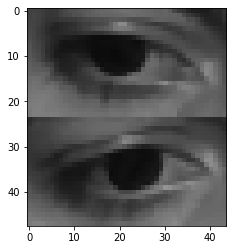

In [5]:
SAMPLE_NUMBER = 2
print(x2_chs_inp[SAMPLE_NUMBER])
print(y_load[SAMPLE_NUMBER])
plt.imshow(x1_load[SAMPLE_NUMBER].reshape((frame_height, frame_width)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

In [6]:
scalers = jload(scaler_dir)
x1_scaler, x2_scaler, _ = scalers

x1 = x1_load / x1_scaler
x2 = x2_scaler.transform(x2_chs_inp)

y_scalers = y_load.max(0)
y = y_load / y_scalers

scalers[2] = y_scalers

jdump(scalers, et_sbj_dir + "scalers.bin")

/home/mostafa/Projects/EyeTracker/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


['subjects/1/eye_tracking/scalers.bin']

In [7]:
y1, y2 = y[:, 0], y[:, 1]

In [10]:
x1_shf, x2_shf, y1_shf, y2_shf = shuffle(x1, x2, y1, y2)

n_train = int(R_TRAIN * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y1_train, y2_train = y1_shf[:n_train], y2_shf[:n_train]
y1_test, y2_test = y1_shf[n_train:], y2_shf[n_train:]

print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape,
      x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape)

(595, 48, 44, 1) (105, 48, 44, 1) (595,) (105,) (595, 7) (105, 7) (595,) (105,)


In [11]:
x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]
y_train_list = [y1_train, y2_train]
y_test_list = [y1_test, y2_test]

In [12]:
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)

In [13]:
model = load_model(trained_models_dir + MODEL_FOL)
print(model.summary())

2021-10-19 13:53:41.284105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 13:53:41.284843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-19 13:53:41.284993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-19 13:53:41.285106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-19 13:53:41.285216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 48, 44, 16)   416         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 24, 22, 16)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 24, 22, 32)   12832       max_pooling2d_12[0][0]           
____________________________________________________________________________________________

In [14]:
for layer in model.layers[:-TRAINABLE_LAYERS]:
    layer.trainable = False
for layer in model.layers:
    print(layer, layer.trainable)

print(model.summary())

<keras.engine.input_layer.InputLayer object at 0x7fd36a945b80> False
<keras.layers.convolutional.Conv2D object at 0x7fd36b50da90> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd36ac3c2b0> False
<keras.layers.convolutional.Conv2D object at 0x7fd36ac3c5b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd36ac3cdf0> False
<keras.layers.convolutional.Conv2D object at 0x7fd36abf2130> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd36abf2970> False
<keras.layers.core.Flatten object at 0x7fd36abf2250> False
<keras.layers.core.Dense object at 0x7fd36abf2eb0> False
<keras.engine.input_layer.InputLayer object at 0x7fd36abfa610> False
<keras.layers.merge.Concatenate object at 0x7fd36abfaa30> False
<keras.layers.core.Dense object at 0x7fd36abfaac0> False
<keras.layers.core.Dense object at 0x7fd36ac04130> False
<keras.layers.core.Dense object at 0x7fd36ac04250> False
<keras.layers.core.Dense object at 0x7fd36ac04820> False
<keras.layers.core.Dense object at 0x7fd36ac0d2e0> F

In [15]:
results = model.fit(x_train_list,
                    y_train_list,
                    validation_data=(x_test_list, y_test_list),
                    epochs=N_EPOCHS,
                    callbacks=cb)

2021-10-19 13:54:00.028173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60
19/19 [==============================] - 2s 50ms/step - loss: 0.2661 - dense_53_loss: 0.1246 - dense_54_loss: 0.1415 - val_loss: 0.2031 - val_dense_53_loss: 0.0984 - val_dense_54_loss: 0.1047
Epoch 2/60
19/19 [==============================] - 1s 39ms/step - loss: 0.2310 - dense_53_loss: 0.1149 - dense_54_loss: 0.1162 - val_loss: 0.1777 - val_dense_53_loss: 0.0847 - val_dense_54_loss: 0.0931
Epoch 3/60
19/19 [==============================] - 1s 38ms/step - loss: 0.2163 - dense_53_loss: 0.1071 - dense_54_loss: 0.1092 - val_loss: 0.1758 - val_dense_53_loss: 0.0793 - val_dense_54_loss: 0.0965
Epoch 4/60
19/19 [==============================] - 1s 38ms/step - loss: 0.2137 - dense_53_loss: 0.1027 - dense_54_loss: 0.1110 - val_loss: 0.1723 - val_dense_53_loss: 0.0780 - val_dense_54_loss: 0.0943
Epoch 5/60
19/19 [==============================] - 1s 38ms/step - loss: 0.2078 - dense_53_loss: 0.1017 - dense_54_loss: 0.1061 - val_loss: 0.1631 - val_dense_53_loss: 0.0764 - val_dense_5

In [16]:
yhat_train_list = model.predict(x_train_list)
yhat_test_list = model.predict(x_test_list)
    
y_train = np.concatenate((np.expand_dims(y_train_list[0], 1),
                          np.expand_dims(y_train_list[1], 1)), 1)
yhat_train = np.concatenate((yhat_train_list[0], yhat_train_list[1]), 1)
y_test = np.concatenate((np.expand_dims(y_test_list[0], 1),
                                np.expand_dims(y_test_list[1], 1)), 1)
yhat_test = np.concatenate((yhat_test_list[0], yhat_test_list[1]), 1)

In [17]:
train_loss = np.abs(y_train - yhat_train).sum(0) / n_train
test_loss = np.abs(y_test - yhat_test).sum(0) / n_test

print(train_loss, test_loss)

[0.0813702  0.07844169] [0.05329136 0.05114581]


Train
[2995 1422]
[2977 1425]
Test
[1797  474]
[1787  475]


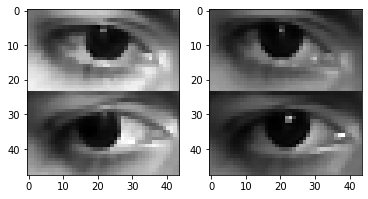

In [24]:
NUM = 4
print("Train")
sample_train = (y_train[NUM] * y_scalers).astype(np.uint32)
yhat_train[NUM][yhat_train[NUM] < 0] = 0
sample_train_hat = (yhat_train[NUM] * y_scalers).astype(np.uint32)
print(sample_train)
print(sample_train_hat)

print("Test")
sample_test = (y_test[NUM] * y_scalers).astype(np.uint32)
yhat_test[NUM][yhat_test[NUM] < 0] = 0
sample_test_hat = (yhat_test[NUM] * y_scalers).astype(np.uint32)
print(sample_test)
print(sample_test_hat)

_, ax = plt.subplots(1,2)
ax[0].imshow((x_train_list[0][NUM] * 255).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray")
ax[1].imshow((x_test_list[0][NUM] * 255).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray")

In [25]:
model.save(et_sbj_dir + "model")

2021-10-19 13:58:03.065769: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: subjects/1/eye_tracking/model/assets
